# Predicting Divorce Rates With Naive Bayes

# TLDR: Answer some questions at the bottom of this post and see if you're getting divorced
Yesterday was Valentine's Day and I'm not bitter or anything, but here's a quick post about predicting
divorce rates based on a short panel of questions. Love is temporary, but data science is forever.

This is a super random dataset that I just found on UC Irvine's Machine Learning data respository,
so if it's weird that, for example, all the study participants are from the same region of Turkey, that's why.

The data set is available [here](http://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set)

The code for this project is available on my github [here](http://www.github.com/PSZehder/divorce_rates)

## About the Data
The data comes from this paper hosted [here](https://dergipark.org.tr/en/pub/nevsosbilen/issue/46568/549416)
by Yötem et al. In their paper, they use a standard scale for Gottman couple's therapy called the Divorce Predictor Scale or DPS.
The DPS is a set of 54 questions which subjects answer on a scale of 0 - 4. The questions include:

The study has 170 participants, all heterosexual couples from the Black Sea region of Turkey, ages ranging from 20-64.
The data is nice and clean and almost perfectly balanced between the classes (49% divorcees to 51% not divorced) which
is really convenient. 

In their paper they use a fully connected network, and random binary forest. With 
the neural network they boast an accuracy of 97.6%, but that goes up to 98.8% with some feature selection. 

## Objective
The goal for this blog post is to create a classifier for divorce rates based on this data and identify the most important
predictors of divorce in Turkish couples from the Black Sea region ages 20-64. That way, if I ever meet a
Turkish person from the Black Sea region (aged 20-64, of course) I can tell them how likely they are to divorce
their significant other. 

Also, assuming the classifier works for non Turkish couples, I can help my friends predict the odds they break up with
their loved ones. I'm not sure if that's good or bad.

## First Impressions
At face value this prediction task doesn't look to hard. The dataset is relatively small, but the feature space is also
really small (only 54 features). It's also binary classification which is an easier task than multiclass, generally speaking.

We should be able to overfit very easily, so as much as I love really deep learning, that's probably not the move here.
(The other reason it's probably not the move is that my GPU is currently busy training a forthcoming project, stay tuned)
In fact, as part of my New Year's resolution of diversifying my diet I won't even use PyTorch for this project.

Something like Naive Bayes which is emperically well suited for small datasets should perform relatively well here.

First off we can check to see if any of the predictors are correllated

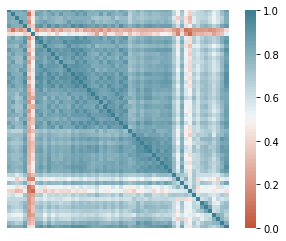

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('data/divorce.csv', ';')
corr = data.corr()

ax = sns.heatmap(
    corr,
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

plt.axis('off')
plt.show()

All of the features in the dataset have a positive correlation so the plot above has been normalized to the range $[0, 1]$.
The red bands denote zero correlation between questions 6/7 and the other questions. Those questions are
6. We don't have time at home as partners
7. We are like two strangers who share the same environment at home rather than a family

What we learn from this is even if you and your beloved rarely spend quality time together and ice each other out like
strangers, there's no correllation with the other things going on in your relationship. So emperically speaking, fixing/
worsening the parts of your relationship that pertain to the above questions
shouldn't impact other areas of your relationship.

(more importantly we see that the correllation is generally pretty low between predictors. This means the simple
approach of "throw all the predictors into a model" should work okay since we won't be adding any redundant/spurious predictors)

## Naive Bayes

We can start with a Naive Bayes Classifier

Accuracy: 0.971


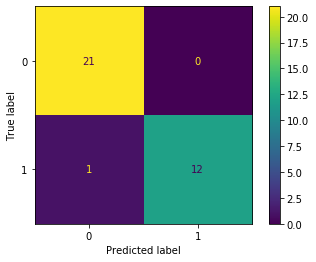

In [139]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

# load the data and shuffle into train/test split
train_ratio = 0.8

def multinb(train_ratio, data, feat_idx=None):
    data = data.sample(frac=1)
    train = data[:int(len(data) * train_ratio)]
    test = data[int(len(data) * train_ratio):]
    if feat_idx is None:
        train = (train[['Class']].transpose().squeeze(0), train.drop(['Class'], axis=1, inplace=False))
        test = (test[['Class']].transpose().squeeze(0), test.drop(['Class'], axis=1, inplace=False))
    else:
        train = (train[['Class']].transpose().squeeze(0), train.iloc[:, feat_idx]) 
        test = (test[['Class']].transpose().squeeze(0), test.iloc[:, feat_idx])
    naive_bayes = MultinomialNB()
    naive_bayes.fit(train[1], train[0])
    return naive_bayes, train, test

# split data and train classifier
nbclassifier, train, test = multinb(train_ratio, data)

# get results
print('Accuracy: %.3f' % nbclassifier.score(test[1], test[0]))

plot_confusion_matrix(nbclassifier, test[1], test[0])

In the code above, the `feat_idx` parameter lets us train a model with fewer features by specifying their indices.

I noticed that the performance of the model is really dependent on the train test split which makes sense given the
small dataset size. I also noticed that the performance of the model is pretty good even with small amounts of training data. So,
just for fun, let's conduct a small study on the model with respect to the amount of data. We'll average the
model performance across many different shufflings of the data into train/test and reduce the amount of data each time
to see how the performance degrades with a smaller dataset. Intutitively, as the train set gets smaller, we should
generalize to the test set more poorly.

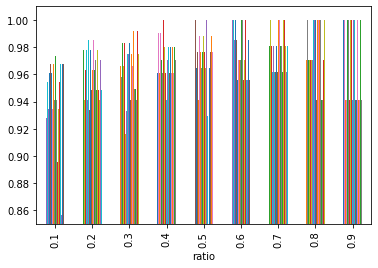

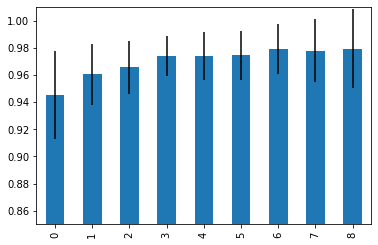

In [140]:
import numpy as np

n = 100 # number of samples to compute mean performance
k = 10 # number of ratios to sample at, in 0.1s

results = np.zeros((k - 1, n + 1))

for j in range(k - 1):
    ratio = (j + 1)/ 10
    results[j][0] = ratio
    for i in range(n):
        classifier, _, test = multinb(ratio, data)
        results[j][i + 1] = classifier.score(test[1], test[0])

means = np.mean(results[:, 1:], axis=1)
sd = np.std(results[:, 1:], axis=1)
errors = pd.DataFrame([[-sd[i], sd[i]] for i in range(k - 1)])

means = pd.DataFrame(means)

results = pd.DataFrame(results)
results.columns = ['ratio', *['trial%s' % s for s in range(n)]]
ax1 = results.plot.bar(x='ratio')
ax1.set_ylim(0.85, 1.01)
ax1.get_legend().remove()

ax2 = means.plot.bar(yerr=errors)
ax2.set_ylim(0.85, 1.01)
ax2.get_legend().remove()

We see that performance is better with a larger percentage of the data, but variance is higher at either high or low
percentage of the data in the train set. We also see that the performance really doesn't vary too much, verifying that
naive Bayes performs well even on very small datasets.

We see that a 70/30 split has low variance, good accuracy, and aligns with common rules of thumb about splitting your
dataset.

With that in mind, we can train the classifier again using this train-test split and extract the most important features
to the classification

(The code for the most important features is based on
[this stack exchange post](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers))

In [141]:
num_questions = 10

# split data and train classifier
nbclassifier, train, test = multinb(train_ratio=0.7, data=data)

# get results
print('Accuracy: %.3f' % nbclassifier.score(test[1], test[0]))

def get_q(idx, mapping='data/questions.txt'):
    with open(mapping, 'r') as mapfile:
        mapping = [line for line in mapfile]
    return mapping[idx]
    
def print_top_n(clf, n, mapping='data/questions.txt'): 
    topn = np.argsort(clf.coef_[0])[-n:]
    print("%s: \n %s" % ('Important Questions', " ".join(get_q(j, mapping) for j in topn)))
    return topn

# extract the most salient features
topn_idx = print_top_n(nbclassifier, num_questions)

Accuracy: 0.981
Important Questions: 
 52. I wouldn't hesitate to tell my spouse about her/his inadequacy.
 50. I'm not actually the one who's guilty about what I'm accused of.
 49. I have nothing to do with what I've been accused of.
 31. I feel aggressive when I argue with my spouse.
 43. I mostly stay silent to calm the environment a little bit.
 38. I hate my spouse's way of open a subject.
 41. When I talk to my spouse about something, my calm suddenly breaks.
 40. We're just starting a discussion before I know what's going on.
 37. My discussion with my spouse is not calm.
 39. Our discussions often occur suddenly.



In honesty, these questions seem like a bunch of big red flags to me, so we've used data science to confirm the obvious:
If you don't get a long with and are constantly hostile towards your significant other, you'll probably get divorced.

Now, let's train a reduced classifier on just these 10 questions. Then you can input your own answers and predict how
likely you are to get divorced! What fun!

First, let's see how the smaller model performs on our data:

Accuracy: 0.865


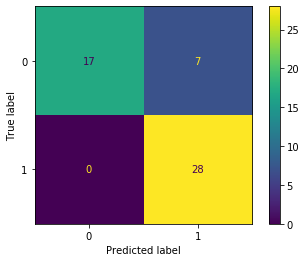

In [145]:
smallernb, train, test = multinb(train_ratio=0.7, data=data, feat_idx=topn_idx)
# get results
print('Accuracy: %.3f' % smallernb.score(test[1], test[0]))
plot_confusion_matrix(smallernb, test[1], test[0])

We can see that the performance is not as good as the model with all the features, but it has 1/5 of the features. Even
though the accuracy is much lower, this is still useful since we need to ask far fewer questions to render a prediction.

From the confusion matrix we also see that this reduced model tends towards false positives over false negatives. So if
you answer the questions below and aren't happy with your results, remember that the model tends to think people will
get divorced more often than they actually do.

With all this in mind, try out the classifier with your own responses/data (if you'd like)

In [157]:
from sklearn.preprocessing import normalize

print('Answer on a Scale of 1-5 (1 = Strongly Disagree, 5 = Strongly Agree)')
responses = []
for i in topn_idx:
    response = input(get_q(i))
    if response is '':
        response = 0
    else:
        response = int(response) - 1
    responses.append(response)

responses = np.array(responses)
responses = np.expand_dims(responses, axis=0)

result = smallernb.predict(responses)
probab = normalize(smallernb.predict_proba(responses))

def print_conclusion(result, probab):
    result_msg = 'DIVORCE' if result[0] == 1 else 'NO DIVORCE'
    likelihood = probab[0][result[0]]
    print('Congratulations! We Predict: %s with %.5f\% confidence' % (result_msg, likelihood))
        
print_conclusion(result, probab)

Answer on a Scale of 1-5 (1 = Strongly Disagree, 5 = Strongly Agree)
Prediction: DIVORCE with 0.92725 confidence
